# LSTM CNN Autoencoder异常侦测

该Notebook改自[这个github repo](https://github.com/hashemsellat/Video-Anomaly-Detection)。

需要注意的是以下代码在tensorflow 2.0.0版本下无法运行，因为有memory leak的问题，详情见[该链接](https://github.com/tensorflow/tensorflow/issues/33178)。可以通过升级到tensorflow 2.1.0解决，不过需要同时[升级Microsoft Visual C++](https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads)，否则会报错，见[这里] (https://github.com/tensorflow/tensorflow/issues/35618)和[这里](https://github.com/tensorflow/tensorflow/issues/35749)。

载入必须的库。

In [1]:
class Config:
  DATASET_PATH ="./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  SINGLE_TEST_PATH = "./data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032"
  BATCH_SIZE = 4
  BATCH_NUM = 40
  EPOCHS = 3
  MODEL_PATH = "../model_lstm.hdf5"

In [2]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LayerNormalization 

In [5]:
print(tf.__version__)

2.1.0


In [6]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

实验以上函数，检验函数的处理结果。

In [7]:
clips = []
# loop over the training folders (Train000,Train001,..)
for f in sorted(listdir(Config.DATASET_PATH)):
    if isdir(join(Config.DATASET_PATH, f)):
        all_frames = []
        # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
        for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)

In [8]:
training_set = get_training_set()

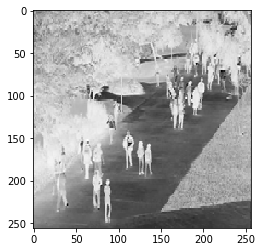

In [9]:
plt.imshow(training_set[95][2][:, :, 0], cmap='binary')

In [10]:
print(len(training_set))
print(all_frames[0].shape)

1360
(256, 256)


现在需要将上述数据处理流程改为一个Data Generator，从而显存较小的普通GPU也能进行运算。
数据处理流程如下：

1. 从train目录中依次读入每个子目录下的tif文件
2. 每读完一个子目录下的所有tif文件后，依照不同的strides从中抽取10张作为一个视频截图序列

因此，如果要将上述一次性处理的模式改为Data Generator，我们需要修改get_train_data函数，在其生成了clip之后转换为tensor并依照所需batch_size针对生成的clips进行yield操作。

In [17]:
def get_training_generator(training_set, batch_size=4):
    """
    Returns
    -------
    An iterator
        An iterator of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    total_clips_num = len(training_set)
    if batch_size <=1:
        batch_size = 1
    iter_num = total_clips_num // batch_size + 1   
    start = 0
    end = start + batch_size
    counter = 0
    
    # loop over the training folders (Train000,Train001,..)
    while True:              
            out_clips = np.array(training_set[start : end]).reshape(-1, 10, 256, 256, 1)
            counter += 1
            yield (out_clips, out_clips)
            start += batch_size
            end += batch_size
            if counter < iter_num:
                counter = 0
            
  

检查generator是否正确。

In [18]:
for i, d in enumerate(get_training_generator(training_set, batch_size=400)):
    print(i, np.array_equal(d[0], d[1]), d[0].shape)

0 True (400, 10, 256, 256, 1)
1 True (400, 10, 256, 256, 1)
2 True (400, 10, 256, 256, 1)
3 True (160, 10, 256, 256, 1)
4 True (0, 10, 256, 256, 1)
5 True (0, 10, 256, 256, 1)
6 True (0, 10, 256, 256, 1)
7 True (0, 10, 256, 256, 1)
8 True (0, 10, 256, 256, 1)
9 True (0, 10, 256, 256, 1)
10 True (0, 10, 256, 256, 1)
11 True (0, 10, 256, 256, 1)
12 True (0, 10, 256, 256, 1)
13 True (0, 10, 256, 256, 1)
14 True (0, 10, 256, 256, 1)
15 True (0, 10, 256, 256, 1)
16 True (0, 10, 256, 256, 1)
17 True (0, 10, 256, 256, 1)
18 True (0, 10, 256, 256, 1)
19 True (0, 10, 256, 256, 1)
20 True (0, 10, 256, 256, 1)
21 True (0, 10, 256, 256, 1)
22 True (0, 10, 256, 256, 1)
23 True (0, 10, 256, 256, 1)
24 True (0, 10, 256, 256, 1)
25 True (0, 10, 256, 256, 1)
26 True (0, 10, 256, 256, 1)
27 True (0, 10, 256, 256, 1)
28 True (0, 10, 256, 256, 1)
29 True (0, 10, 256, 256, 1)
30 True (0, 10, 256, 256, 1)
31 True (0, 10, 256, 256, 1)
32 True (0, 10, 256, 256, 1)
33 True (0, 10, 256, 256, 1)
34 True (0, 10, 

647 True (0, 10, 256, 256, 1)
648 True (0, 10, 256, 256, 1)
649 True (0, 10, 256, 256, 1)
650 True (0, 10, 256, 256, 1)
651 True (0, 10, 256, 256, 1)
652 True (0, 10, 256, 256, 1)
653 True (0, 10, 256, 256, 1)
654 True (0, 10, 256, 256, 1)
655 True (0, 10, 256, 256, 1)
656 True (0, 10, 256, 256, 1)
657 True (0, 10, 256, 256, 1)
658 True (0, 10, 256, 256, 1)
659 True (0, 10, 256, 256, 1)
660 True (0, 10, 256, 256, 1)
661 True (0, 10, 256, 256, 1)
662 True (0, 10, 256, 256, 1)
663 True (0, 10, 256, 256, 1)
664 True (0, 10, 256, 256, 1)
665 True (0, 10, 256, 256, 1)
666 True (0, 10, 256, 256, 1)
667 True (0, 10, 256, 256, 1)
668 True (0, 10, 256, 256, 1)
669 True (0, 10, 256, 256, 1)
670 True (0, 10, 256, 256, 1)
671 True (0, 10, 256, 256, 1)
672 True (0, 10, 256, 256, 1)
673 True (0, 10, 256, 256, 1)
674 True (0, 10, 256, 256, 1)
675 True (0, 10, 256, 256, 1)
676 True (0, 10, 256, 256, 1)
677 True (0, 10, 256, 256, 1)
678 True (0, 10, 256, 256, 1)
679 True (0, 10, 256, 256, 1)
680 True (

1222 True (0, 10, 256, 256, 1)
1223 True (0, 10, 256, 256, 1)
1224 True (0, 10, 256, 256, 1)
1225 True (0, 10, 256, 256, 1)
1226 True (0, 10, 256, 256, 1)
1227 True (0, 10, 256, 256, 1)
1228 True (0, 10, 256, 256, 1)
1229 True (0, 10, 256, 256, 1)
1230 True (0, 10, 256, 256, 1)
1231 True (0, 10, 256, 256, 1)
1232 True (0, 10, 256, 256, 1)
1233 True (0, 10, 256, 256, 1)
1234 True (0, 10, 256, 256, 1)
1235 True (0, 10, 256, 256, 1)
1236 True (0, 10, 256, 256, 1)
1237 True (0, 10, 256, 256, 1)
1238 True (0, 10, 256, 256, 1)
1239 True (0, 10, 256, 256, 1)
1240 True (0, 10, 256, 256, 1)
1241 True (0, 10, 256, 256, 1)
1242 True (0, 10, 256, 256, 1)
1243 True (0, 10, 256, 256, 1)
1244 True (0, 10, 256, 256, 1)
1245 True (0, 10, 256, 256, 1)
1246 True (0, 10, 256, 256, 1)
1247 True (0, 10, 256, 256, 1)
1248 True (0, 10, 256, 256, 1)
1249 True (0, 10, 256, 256, 1)
1250 True (0, 10, 256, 256, 1)
1251 True (0, 10, 256, 256, 1)
1252 True (0, 10, 256, 256, 1)
1253 True (0, 10, 256, 256, 1)
1254 Tru

1813 True (0, 10, 256, 256, 1)
1814 True (0, 10, 256, 256, 1)
1815 True (0, 10, 256, 256, 1)
1816 True (0, 10, 256, 256, 1)
1817 True (0, 10, 256, 256, 1)
1818 True (0, 10, 256, 256, 1)
1819 True (0, 10, 256, 256, 1)
1820 True (0, 10, 256, 256, 1)
1821 True (0, 10, 256, 256, 1)
1822 True (0, 10, 256, 256, 1)
1823 True (0, 10, 256, 256, 1)
1824 True (0, 10, 256, 256, 1)
1825 True (0, 10, 256, 256, 1)
1826 True (0, 10, 256, 256, 1)
1827 True (0, 10, 256, 256, 1)
1828 True (0, 10, 256, 256, 1)
1829 True (0, 10, 256, 256, 1)
1830 True (0, 10, 256, 256, 1)
1831 True (0, 10, 256, 256, 1)
1832 True (0, 10, 256, 256, 1)
1833 True (0, 10, 256, 256, 1)
1834 True (0, 10, 256, 256, 1)
1835 True (0, 10, 256, 256, 1)
1836 True (0, 10, 256, 256, 1)
1837 True (0, 10, 256, 256, 1)
1838 True (0, 10, 256, 256, 1)
1839 True (0, 10, 256, 256, 1)
1840 True (0, 10, 256, 256, 1)
1841 True (0, 10, 256, 256, 1)
1842 True (0, 10, 256, 256, 1)
1843 True (0, 10, 256, 256, 1)
1844 True (0, 10, 256, 256, 1)
1845 Tru

2436 True (0, 10, 256, 256, 1)
2437 True (0, 10, 256, 256, 1)
2438 True (0, 10, 256, 256, 1)
2439 True (0, 10, 256, 256, 1)
2440 True (0, 10, 256, 256, 1)
2441 True (0, 10, 256, 256, 1)
2442 True (0, 10, 256, 256, 1)
2443 True (0, 10, 256, 256, 1)
2444 True (0, 10, 256, 256, 1)
2445 True (0, 10, 256, 256, 1)
2446 True (0, 10, 256, 256, 1)
2447 True (0, 10, 256, 256, 1)
2448 True (0, 10, 256, 256, 1)
2449 True (0, 10, 256, 256, 1)
2450 True (0, 10, 256, 256, 1)
2451 True (0, 10, 256, 256, 1)
2452 True (0, 10, 256, 256, 1)
2453 True (0, 10, 256, 256, 1)
2454 True (0, 10, 256, 256, 1)
2455 True (0, 10, 256, 256, 1)
2456 True (0, 10, 256, 256, 1)
2457 True (0, 10, 256, 256, 1)
2458 True (0, 10, 256, 256, 1)
2459 True (0, 10, 256, 256, 1)
2460 True (0, 10, 256, 256, 1)
2461 True (0, 10, 256, 256, 1)
2462 True (0, 10, 256, 256, 1)
2463 True (0, 10, 256, 256, 1)
2464 True (0, 10, 256, 256, 1)
2465 True (0, 10, 256, 256, 1)
2466 True (0, 10, 256, 256, 1)
2467 True (0, 10, 256, 256, 1)
2468 Tru

2980 True (0, 10, 256, 256, 1)
2981 True (0, 10, 256, 256, 1)
2982 True (0, 10, 256, 256, 1)
2983 True (0, 10, 256, 256, 1)
2984 True (0, 10, 256, 256, 1)
2985 True (0, 10, 256, 256, 1)
2986 True (0, 10, 256, 256, 1)
2987 True (0, 10, 256, 256, 1)
2988 True (0, 10, 256, 256, 1)
2989 True (0, 10, 256, 256, 1)
2990 True (0, 10, 256, 256, 1)
2991 True (0, 10, 256, 256, 1)
2992 True (0, 10, 256, 256, 1)
2993 True (0, 10, 256, 256, 1)
2994 True (0, 10, 256, 256, 1)
2995 True (0, 10, 256, 256, 1)
2996 True (0, 10, 256, 256, 1)
2997 True (0, 10, 256, 256, 1)
2998 True (0, 10, 256, 256, 1)
2999 True (0, 10, 256, 256, 1)
3000 True (0, 10, 256, 256, 1)
3001 True (0, 10, 256, 256, 1)
3002 True (0, 10, 256, 256, 1)
3003 True (0, 10, 256, 256, 1)
3004 True (0, 10, 256, 256, 1)
3005 True (0, 10, 256, 256, 1)
3006 True (0, 10, 256, 256, 1)
3007 True (0, 10, 256, 256, 1)
3008 True (0, 10, 256, 256, 1)
3009 True (0, 10, 256, 256, 1)
3010 True (0, 10, 256, 256, 1)
3011 True (0, 10, 256, 256, 1)
3012 Tru

3605 True (0, 10, 256, 256, 1)
3606 True (0, 10, 256, 256, 1)
3607 True (0, 10, 256, 256, 1)
3608 True (0, 10, 256, 256, 1)
3609 True (0, 10, 256, 256, 1)
3610 True (0, 10, 256, 256, 1)
3611 True (0, 10, 256, 256, 1)
3612 True (0, 10, 256, 256, 1)
3613 True (0, 10, 256, 256, 1)
3614 True (0, 10, 256, 256, 1)
3615 True (0, 10, 256, 256, 1)
3616 True (0, 10, 256, 256, 1)
3617 True (0, 10, 256, 256, 1)
3618 True (0, 10, 256, 256, 1)
3619 True (0, 10, 256, 256, 1)
3620 True (0, 10, 256, 256, 1)
3621 True (0, 10, 256, 256, 1)
3622 True (0, 10, 256, 256, 1)
3623 True (0, 10, 256, 256, 1)
3624 True (0, 10, 256, 256, 1)
3625 True (0, 10, 256, 256, 1)
3626 True (0, 10, 256, 256, 1)
3627 True (0, 10, 256, 256, 1)
3628 True (0, 10, 256, 256, 1)
3629 True (0, 10, 256, 256, 1)
3630 True (0, 10, 256, 256, 1)
3631 True (0, 10, 256, 256, 1)
3632 True (0, 10, 256, 256, 1)
3633 True (0, 10, 256, 256, 1)
3634 True (0, 10, 256, 256, 1)
3635 True (0, 10, 256, 256, 1)
3636 True (0, 10, 256, 256, 1)
3637 Tru

4146 True (0, 10, 256, 256, 1)
4147 True (0, 10, 256, 256, 1)
4148 True (0, 10, 256, 256, 1)
4149 True (0, 10, 256, 256, 1)
4150 True (0, 10, 256, 256, 1)
4151 True (0, 10, 256, 256, 1)
4152 True (0, 10, 256, 256, 1)
4153 True (0, 10, 256, 256, 1)
4154 True (0, 10, 256, 256, 1)
4155 True (0, 10, 256, 256, 1)
4156 True (0, 10, 256, 256, 1)
4157 True (0, 10, 256, 256, 1)
4158 True (0, 10, 256, 256, 1)
4159 True (0, 10, 256, 256, 1)
4160 True (0, 10, 256, 256, 1)
4161 True (0, 10, 256, 256, 1)
4162 True (0, 10, 256, 256, 1)
4163 True (0, 10, 256, 256, 1)
4164 True (0, 10, 256, 256, 1)
4165 True (0, 10, 256, 256, 1)
4166 True (0, 10, 256, 256, 1)
4167 True (0, 10, 256, 256, 1)
4168 True (0, 10, 256, 256, 1)
4169 True (0, 10, 256, 256, 1)
4170 True (0, 10, 256, 256, 1)
4171 True (0, 10, 256, 256, 1)
4172 True (0, 10, 256, 256, 1)
4173 True (0, 10, 256, 256, 1)
4174 True (0, 10, 256, 256, 1)
4175 True (0, 10, 256, 256, 1)
4176 True (0, 10, 256, 256, 1)
4177 True (0, 10, 256, 256, 1)
4178 Tru

4813 True (0, 10, 256, 256, 1)
4814 True (0, 10, 256, 256, 1)
4815 True (0, 10, 256, 256, 1)
4816 True (0, 10, 256, 256, 1)
4817 True (0, 10, 256, 256, 1)
4818 True (0, 10, 256, 256, 1)
4819 True (0, 10, 256, 256, 1)
4820 True (0, 10, 256, 256, 1)
4821 True (0, 10, 256, 256, 1)
4822 True (0, 10, 256, 256, 1)
4823 True (0, 10, 256, 256, 1)
4824 True (0, 10, 256, 256, 1)
4825 True (0, 10, 256, 256, 1)
4826 True (0, 10, 256, 256, 1)
4827 True (0, 10, 256, 256, 1)
4828 True (0, 10, 256, 256, 1)
4829 True (0, 10, 256, 256, 1)
4830 True (0, 10, 256, 256, 1)
4831 True (0, 10, 256, 256, 1)
4832 True (0, 10, 256, 256, 1)
4833 True (0, 10, 256, 256, 1)
4834 True (0, 10, 256, 256, 1)
4835 True (0, 10, 256, 256, 1)
4836 True (0, 10, 256, 256, 1)
4837 True (0, 10, 256, 256, 1)
4838 True (0, 10, 256, 256, 1)
4839 True (0, 10, 256, 256, 1)
4840 True (0, 10, 256, 256, 1)
4841 True (0, 10, 256, 256, 1)
4842 True (0, 10, 256, 256, 1)
4843 True (0, 10, 256, 256, 1)
4844 True (0, 10, 256, 256, 1)
4845 Tru

5479 True (0, 10, 256, 256, 1)
5480 True (0, 10, 256, 256, 1)
5481 True (0, 10, 256, 256, 1)
5482 True (0, 10, 256, 256, 1)
5483 True (0, 10, 256, 256, 1)
5484 True (0, 10, 256, 256, 1)
5485 True (0, 10, 256, 256, 1)
5486 True (0, 10, 256, 256, 1)
5487 True (0, 10, 256, 256, 1)
5488 True (0, 10, 256, 256, 1)
5489 True (0, 10, 256, 256, 1)
5490 True (0, 10, 256, 256, 1)
5491 True (0, 10, 256, 256, 1)
5492 True (0, 10, 256, 256, 1)
5493 True (0, 10, 256, 256, 1)
5494 True (0, 10, 256, 256, 1)
5495 True (0, 10, 256, 256, 1)
5496 True (0, 10, 256, 256, 1)
5497 True (0, 10, 256, 256, 1)
5498 True (0, 10, 256, 256, 1)
5499 True (0, 10, 256, 256, 1)
5500 True (0, 10, 256, 256, 1)
5501 True (0, 10, 256, 256, 1)
5502 True (0, 10, 256, 256, 1)
5503 True (0, 10, 256, 256, 1)
5504 True (0, 10, 256, 256, 1)
5505 True (0, 10, 256, 256, 1)
5506 True (0, 10, 256, 256, 1)
5507 True (0, 10, 256, 256, 1)
5508 True (0, 10, 256, 256, 1)
5509 True (0, 10, 256, 256, 1)
5510 True (0, 10, 256, 256, 1)
5511 Tru

6146 True (0, 10, 256, 256, 1)
6147 True (0, 10, 256, 256, 1)
6148 True (0, 10, 256, 256, 1)
6149 True (0, 10, 256, 256, 1)
6150 True (0, 10, 256, 256, 1)
6151 True (0, 10, 256, 256, 1)
6152 True (0, 10, 256, 256, 1)
6153 True (0, 10, 256, 256, 1)
6154 True (0, 10, 256, 256, 1)
6155 True (0, 10, 256, 256, 1)
6156 True (0, 10, 256, 256, 1)
6157 True (0, 10, 256, 256, 1)
6158 True (0, 10, 256, 256, 1)
6159 True (0, 10, 256, 256, 1)
6160 True (0, 10, 256, 256, 1)
6161 True (0, 10, 256, 256, 1)
6162 True (0, 10, 256, 256, 1)
6163 True (0, 10, 256, 256, 1)
6164 True (0, 10, 256, 256, 1)
6165 True (0, 10, 256, 256, 1)
6166 True (0, 10, 256, 256, 1)
6167 True (0, 10, 256, 256, 1)
6168 True (0, 10, 256, 256, 1)
6169 True (0, 10, 256, 256, 1)
6170 True (0, 10, 256, 256, 1)
6171 True (0, 10, 256, 256, 1)
6172 True (0, 10, 256, 256, 1)
6173 True (0, 10, 256, 256, 1)
6174 True (0, 10, 256, 256, 1)
6175 True (0, 10, 256, 256, 1)
6176 True (0, 10, 256, 256, 1)
6177 True (0, 10, 256, 256, 1)
6178 Tru

6812 True (0, 10, 256, 256, 1)
6813 True (0, 10, 256, 256, 1)
6814 True (0, 10, 256, 256, 1)
6815 True (0, 10, 256, 256, 1)
6816 True (0, 10, 256, 256, 1)
6817 True (0, 10, 256, 256, 1)
6818 True (0, 10, 256, 256, 1)
6819 True (0, 10, 256, 256, 1)
6820 True (0, 10, 256, 256, 1)
6821 True (0, 10, 256, 256, 1)
6822 True (0, 10, 256, 256, 1)
6823 True (0, 10, 256, 256, 1)
6824 True (0, 10, 256, 256, 1)
6825 True (0, 10, 256, 256, 1)
6826 True (0, 10, 256, 256, 1)
6827 True (0, 10, 256, 256, 1)
6828 True (0, 10, 256, 256, 1)
6829 True (0, 10, 256, 256, 1)
6830 True (0, 10, 256, 256, 1)
6831 True (0, 10, 256, 256, 1)
6832 True (0, 10, 256, 256, 1)
6833 True (0, 10, 256, 256, 1)
6834 True (0, 10, 256, 256, 1)
6835 True (0, 10, 256, 256, 1)
6836 True (0, 10, 256, 256, 1)
6837 True (0, 10, 256, 256, 1)
6838 True (0, 10, 256, 256, 1)
6839 True (0, 10, 256, 256, 1)
6840 True (0, 10, 256, 256, 1)
6841 True (0, 10, 256, 256, 1)
6842 True (0, 10, 256, 256, 1)
6843 True (0, 10, 256, 256, 1)
6844 Tru

7479 True (0, 10, 256, 256, 1)
7480 True (0, 10, 256, 256, 1)
7481 True (0, 10, 256, 256, 1)
7482 True (0, 10, 256, 256, 1)
7483 True (0, 10, 256, 256, 1)
7484 True (0, 10, 256, 256, 1)
7485 True (0, 10, 256, 256, 1)
7486 True (0, 10, 256, 256, 1)
7487 True (0, 10, 256, 256, 1)
7488 True (0, 10, 256, 256, 1)
7489 True (0, 10, 256, 256, 1)
7490 True (0, 10, 256, 256, 1)
7491 True (0, 10, 256, 256, 1)
7492 True (0, 10, 256, 256, 1)
7493 True (0, 10, 256, 256, 1)
7494 True (0, 10, 256, 256, 1)
7495 True (0, 10, 256, 256, 1)
7496 True (0, 10, 256, 256, 1)
7497 True (0, 10, 256, 256, 1)
7498 True (0, 10, 256, 256, 1)
7499 True (0, 10, 256, 256, 1)
7500 True (0, 10, 256, 256, 1)
7501 True (0, 10, 256, 256, 1)
7502 True (0, 10, 256, 256, 1)
7503 True (0, 10, 256, 256, 1)
7504 True (0, 10, 256, 256, 1)
7505 True (0, 10, 256, 256, 1)
7506 True (0, 10, 256, 256, 1)
7507 True (0, 10, 256, 256, 1)
7508 True (0, 10, 256, 256, 1)
7509 True (0, 10, 256, 256, 1)
7510 True (0, 10, 256, 256, 1)
7511 Tru

8145 True (0, 10, 256, 256, 1)
8146 True (0, 10, 256, 256, 1)
8147 True (0, 10, 256, 256, 1)
8148 True (0, 10, 256, 256, 1)
8149 True (0, 10, 256, 256, 1)
8150 True (0, 10, 256, 256, 1)
8151 True (0, 10, 256, 256, 1)
8152 True (0, 10, 256, 256, 1)
8153 True (0, 10, 256, 256, 1)
8154 True (0, 10, 256, 256, 1)
8155 True (0, 10, 256, 256, 1)
8156 True (0, 10, 256, 256, 1)
8157 True (0, 10, 256, 256, 1)
8158 True (0, 10, 256, 256, 1)
8159 True (0, 10, 256, 256, 1)
8160 True (0, 10, 256, 256, 1)
8161 True (0, 10, 256, 256, 1)
8162 True (0, 10, 256, 256, 1)
8163 True (0, 10, 256, 256, 1)
8164 True (0, 10, 256, 256, 1)
8165 True (0, 10, 256, 256, 1)
8166 True (0, 10, 256, 256, 1)
8167 True (0, 10, 256, 256, 1)
8168 True (0, 10, 256, 256, 1)
8169 True (0, 10, 256, 256, 1)
8170 True (0, 10, 256, 256, 1)
8171 True (0, 10, 256, 256, 1)
8172 True (0, 10, 256, 256, 1)
8173 True (0, 10, 256, 256, 1)
8174 True (0, 10, 256, 256, 1)
8175 True (0, 10, 256, 256, 1)
8176 True (0, 10, 256, 256, 1)
8177 Tru

8812 True (0, 10, 256, 256, 1)
8813 True (0, 10, 256, 256, 1)
8814 True (0, 10, 256, 256, 1)
8815 True (0, 10, 256, 256, 1)
8816 True (0, 10, 256, 256, 1)
8817 True (0, 10, 256, 256, 1)
8818 True (0, 10, 256, 256, 1)
8819 True (0, 10, 256, 256, 1)
8820 True (0, 10, 256, 256, 1)
8821 True (0, 10, 256, 256, 1)
8822 True (0, 10, 256, 256, 1)
8823 True (0, 10, 256, 256, 1)
8824 True (0, 10, 256, 256, 1)
8825 True (0, 10, 256, 256, 1)
8826 True (0, 10, 256, 256, 1)
8827 True (0, 10, 256, 256, 1)
8828 True (0, 10, 256, 256, 1)
8829 True (0, 10, 256, 256, 1)
8830 True (0, 10, 256, 256, 1)
8831 True (0, 10, 256, 256, 1)
8832 True (0, 10, 256, 256, 1)
8833 True (0, 10, 256, 256, 1)
8834 True (0, 10, 256, 256, 1)
8835 True (0, 10, 256, 256, 1)
8836 True (0, 10, 256, 256, 1)
8837 True (0, 10, 256, 256, 1)
8838 True (0, 10, 256, 256, 1)
8839 True (0, 10, 256, 256, 1)
8840 True (0, 10, 256, 256, 1)
8841 True (0, 10, 256, 256, 1)
8842 True (0, 10, 256, 256, 1)
8843 True (0, 10, 256, 256, 1)
8844 Tru

9478 True (0, 10, 256, 256, 1)
9479 True (0, 10, 256, 256, 1)
9480 True (0, 10, 256, 256, 1)
9481 True (0, 10, 256, 256, 1)
9482 True (0, 10, 256, 256, 1)
9483 True (0, 10, 256, 256, 1)
9484 True (0, 10, 256, 256, 1)
9485 True (0, 10, 256, 256, 1)
9486 True (0, 10, 256, 256, 1)
9487 True (0, 10, 256, 256, 1)
9488 True (0, 10, 256, 256, 1)
9489 True (0, 10, 256, 256, 1)
9490 True (0, 10, 256, 256, 1)
9491 True (0, 10, 256, 256, 1)
9492 True (0, 10, 256, 256, 1)
9493 True (0, 10, 256, 256, 1)
9494 True (0, 10, 256, 256, 1)
9495 True (0, 10, 256, 256, 1)
9496 True (0, 10, 256, 256, 1)
9497 True (0, 10, 256, 256, 1)
9498 True (0, 10, 256, 256, 1)
9499 True (0, 10, 256, 256, 1)
9500 True (0, 10, 256, 256, 1)
9501 True (0, 10, 256, 256, 1)
9502 True (0, 10, 256, 256, 1)
9503 True (0, 10, 256, 256, 1)
9504 True (0, 10, 256, 256, 1)
9505 True (0, 10, 256, 256, 1)
9506 True (0, 10, 256, 256, 1)
9507 True (0, 10, 256, 256, 1)
9508 True (0, 10, 256, 256, 1)
9509 True (0, 10, 256, 256, 1)
9510 Tru

10145 True (0, 10, 256, 256, 1)
10146 True (0, 10, 256, 256, 1)
10147 True (0, 10, 256, 256, 1)
10148 True (0, 10, 256, 256, 1)
10149 True (0, 10, 256, 256, 1)
10150 True (0, 10, 256, 256, 1)
10151 True (0, 10, 256, 256, 1)
10152 True (0, 10, 256, 256, 1)
10153 True (0, 10, 256, 256, 1)
10154 True (0, 10, 256, 256, 1)
10155 True (0, 10, 256, 256, 1)
10156 True (0, 10, 256, 256, 1)
10157 True (0, 10, 256, 256, 1)
10158 True (0, 10, 256, 256, 1)
10159 True (0, 10, 256, 256, 1)
10160 True (0, 10, 256, 256, 1)
10161 True (0, 10, 256, 256, 1)
10162 True (0, 10, 256, 256, 1)
10163 True (0, 10, 256, 256, 1)
10164 True (0, 10, 256, 256, 1)
10165 True (0, 10, 256, 256, 1)
10166 True (0, 10, 256, 256, 1)
10167 True (0, 10, 256, 256, 1)
10168 True (0, 10, 256, 256, 1)
10169 True (0, 10, 256, 256, 1)
10170 True (0, 10, 256, 256, 1)
10171 True (0, 10, 256, 256, 1)
10172 True (0, 10, 256, 256, 1)
10173 True (0, 10, 256, 256, 1)
10174 True (0, 10, 256, 256, 1)
10175 True (0, 10, 256, 256, 1)
10176 Tr

10811 True (0, 10, 256, 256, 1)
10812 True (0, 10, 256, 256, 1)
10813 True (0, 10, 256, 256, 1)
10814 True (0, 10, 256, 256, 1)
10815 True (0, 10, 256, 256, 1)
10816 True (0, 10, 256, 256, 1)
10817 True (0, 10, 256, 256, 1)
10818 True (0, 10, 256, 256, 1)
10819 True (0, 10, 256, 256, 1)
10820 True (0, 10, 256, 256, 1)
10821 True (0, 10, 256, 256, 1)
10822 True (0, 10, 256, 256, 1)
10823 True (0, 10, 256, 256, 1)
10824 True (0, 10, 256, 256, 1)
10825 True (0, 10, 256, 256, 1)
10826 True (0, 10, 256, 256, 1)
10827 True (0, 10, 256, 256, 1)
10828 True (0, 10, 256, 256, 1)
10829 True (0, 10, 256, 256, 1)
10830 True (0, 10, 256, 256, 1)
10831 True (0, 10, 256, 256, 1)
10832 True (0, 10, 256, 256, 1)
10833 True (0, 10, 256, 256, 1)
10834 True (0, 10, 256, 256, 1)
10835 True (0, 10, 256, 256, 1)
10836 True (0, 10, 256, 256, 1)
10837 True (0, 10, 256, 256, 1)
10838 True (0, 10, 256, 256, 1)
10839 True (0, 10, 256, 256, 1)
10840 True (0, 10, 256, 256, 1)
10841 True (0, 10, 256, 256, 1)
10842 Tr

11478 True (0, 10, 256, 256, 1)
11479 True (0, 10, 256, 256, 1)
11480 True (0, 10, 256, 256, 1)
11481 True (0, 10, 256, 256, 1)
11482 True (0, 10, 256, 256, 1)
11483 True (0, 10, 256, 256, 1)
11484 True (0, 10, 256, 256, 1)
11485 True (0, 10, 256, 256, 1)
11486 True (0, 10, 256, 256, 1)
11487 True (0, 10, 256, 256, 1)
11488 True (0, 10, 256, 256, 1)
11489 True (0, 10, 256, 256, 1)
11490 True (0, 10, 256, 256, 1)
11491 True (0, 10, 256, 256, 1)
11492 True (0, 10, 256, 256, 1)
11493 True (0, 10, 256, 256, 1)
11494 True (0, 10, 256, 256, 1)
11495 True (0, 10, 256, 256, 1)
11496 True (0, 10, 256, 256, 1)
11497 True (0, 10, 256, 256, 1)
11498 True (0, 10, 256, 256, 1)
11499 True (0, 10, 256, 256, 1)
11500 True (0, 10, 256, 256, 1)
11501 True (0, 10, 256, 256, 1)
11502 True (0, 10, 256, 256, 1)
11503 True (0, 10, 256, 256, 1)
11504 True (0, 10, 256, 256, 1)
11505 True (0, 10, 256, 256, 1)
11506 True (0, 10, 256, 256, 1)
11507 True (0, 10, 256, 256, 1)
11508 True (0, 10, 256, 256, 1)
11509 Tr

12144 True (0, 10, 256, 256, 1)
12145 True (0, 10, 256, 256, 1)
12146 True (0, 10, 256, 256, 1)
12147 True (0, 10, 256, 256, 1)
12148 True (0, 10, 256, 256, 1)
12149 True (0, 10, 256, 256, 1)
12150 True (0, 10, 256, 256, 1)
12151 True (0, 10, 256, 256, 1)
12152 True (0, 10, 256, 256, 1)
12153 True (0, 10, 256, 256, 1)
12154 True (0, 10, 256, 256, 1)
12155 True (0, 10, 256, 256, 1)
12156 True (0, 10, 256, 256, 1)
12157 True (0, 10, 256, 256, 1)
12158 True (0, 10, 256, 256, 1)
12159 True (0, 10, 256, 256, 1)
12160 True (0, 10, 256, 256, 1)
12161 True (0, 10, 256, 256, 1)
12162 True (0, 10, 256, 256, 1)
12163 True (0, 10, 256, 256, 1)
12164 True (0, 10, 256, 256, 1)
12165 True (0, 10, 256, 256, 1)
12166 True (0, 10, 256, 256, 1)
12167 True (0, 10, 256, 256, 1)
12168 True (0, 10, 256, 256, 1)
12169 True (0, 10, 256, 256, 1)
12170 True (0, 10, 256, 256, 1)
12171 True (0, 10, 256, 256, 1)
12172 True (0, 10, 256, 256, 1)
12173 True (0, 10, 256, 256, 1)
12174 True (0, 10, 256, 256, 1)
12175 Tr

12811 True (0, 10, 256, 256, 1)
12812 True (0, 10, 256, 256, 1)
12813 True (0, 10, 256, 256, 1)
12814 True (0, 10, 256, 256, 1)
12815 True (0, 10, 256, 256, 1)
12816 True (0, 10, 256, 256, 1)
12817 True (0, 10, 256, 256, 1)
12818 True (0, 10, 256, 256, 1)
12819 True (0, 10, 256, 256, 1)
12820 True (0, 10, 256, 256, 1)
12821 True (0, 10, 256, 256, 1)
12822 True (0, 10, 256, 256, 1)
12823 True (0, 10, 256, 256, 1)
12824 True (0, 10, 256, 256, 1)
12825 True (0, 10, 256, 256, 1)
12826 True (0, 10, 256, 256, 1)
12827 True (0, 10, 256, 256, 1)
12828 True (0, 10, 256, 256, 1)
12829 True (0, 10, 256, 256, 1)
12830 True (0, 10, 256, 256, 1)
12831 True (0, 10, 256, 256, 1)
12832 True (0, 10, 256, 256, 1)
12833 True (0, 10, 256, 256, 1)
12834 True (0, 10, 256, 256, 1)
12835 True (0, 10, 256, 256, 1)
12836 True (0, 10, 256, 256, 1)
12837 True (0, 10, 256, 256, 1)
12838 True (0, 10, 256, 256, 1)
12839 True (0, 10, 256, 256, 1)
12840 True (0, 10, 256, 256, 1)
12841 True (0, 10, 256, 256, 1)
12842 Tr

13477 True (0, 10, 256, 256, 1)
13478 True (0, 10, 256, 256, 1)
13479 True (0, 10, 256, 256, 1)
13480 True (0, 10, 256, 256, 1)
13481 True (0, 10, 256, 256, 1)
13482 True (0, 10, 256, 256, 1)
13483 True (0, 10, 256, 256, 1)
13484 True (0, 10, 256, 256, 1)
13485 True (0, 10, 256, 256, 1)
13486 True (0, 10, 256, 256, 1)
13487 True (0, 10, 256, 256, 1)
13488 True (0, 10, 256, 256, 1)
13489 True (0, 10, 256, 256, 1)
13490 True (0, 10, 256, 256, 1)
13491 True (0, 10, 256, 256, 1)
13492 True (0, 10, 256, 256, 1)
13493 True (0, 10, 256, 256, 1)
13494 True (0, 10, 256, 256, 1)
13495 True (0, 10, 256, 256, 1)
13496 True (0, 10, 256, 256, 1)
13497 True (0, 10, 256, 256, 1)
13498 True (0, 10, 256, 256, 1)
13499 True (0, 10, 256, 256, 1)
13500 True (0, 10, 256, 256, 1)
13501 True (0, 10, 256, 256, 1)
13502 True (0, 10, 256, 256, 1)
13503 True (0, 10, 256, 256, 1)
13504 True (0, 10, 256, 256, 1)
13505 True (0, 10, 256, 256, 1)
13506 True (0, 10, 256, 256, 1)
13507 True (0, 10, 256, 256, 1)
13508 Tr

14144 True (0, 10, 256, 256, 1)
14145 True (0, 10, 256, 256, 1)
14146 True (0, 10, 256, 256, 1)
14147 True (0, 10, 256, 256, 1)
14148 True (0, 10, 256, 256, 1)
14149 True (0, 10, 256, 256, 1)
14150 True (0, 10, 256, 256, 1)
14151 True (0, 10, 256, 256, 1)
14152 True (0, 10, 256, 256, 1)
14153 True (0, 10, 256, 256, 1)
14154 True (0, 10, 256, 256, 1)
14155 True (0, 10, 256, 256, 1)
14156 True (0, 10, 256, 256, 1)
14157 True (0, 10, 256, 256, 1)
14158 True (0, 10, 256, 256, 1)
14159 True (0, 10, 256, 256, 1)
14160 True (0, 10, 256, 256, 1)
14161 True (0, 10, 256, 256, 1)
14162 True (0, 10, 256, 256, 1)
14163 True (0, 10, 256, 256, 1)
14164 True (0, 10, 256, 256, 1)
14165 True (0, 10, 256, 256, 1)
14166 True (0, 10, 256, 256, 1)
14167 True (0, 10, 256, 256, 1)
14168 True (0, 10, 256, 256, 1)
14169 True (0, 10, 256, 256, 1)
14170 True (0, 10, 256, 256, 1)
14171 True (0, 10, 256, 256, 1)
14172 True (0, 10, 256, 256, 1)
14173 True (0, 10, 256, 256, 1)
14174 True (0, 10, 256, 256, 1)
14175 Tr

14810 True (0, 10, 256, 256, 1)
14811 True (0, 10, 256, 256, 1)
14812 True (0, 10, 256, 256, 1)
14813 True (0, 10, 256, 256, 1)
14814 True (0, 10, 256, 256, 1)
14815 True (0, 10, 256, 256, 1)
14816 True (0, 10, 256, 256, 1)
14817 True (0, 10, 256, 256, 1)
14818 True (0, 10, 256, 256, 1)
14819 True (0, 10, 256, 256, 1)
14820 True (0, 10, 256, 256, 1)
14821 True (0, 10, 256, 256, 1)
14822 True (0, 10, 256, 256, 1)
14823 True (0, 10, 256, 256, 1)
14824 True (0, 10, 256, 256, 1)
14825 True (0, 10, 256, 256, 1)
14826 True (0, 10, 256, 256, 1)
14827 True (0, 10, 256, 256, 1)
14828 True (0, 10, 256, 256, 1)
14829 True (0, 10, 256, 256, 1)
14830 True (0, 10, 256, 256, 1)
14831 True (0, 10, 256, 256, 1)
14832 True (0, 10, 256, 256, 1)
14833 True (0, 10, 256, 256, 1)
14834 True (0, 10, 256, 256, 1)
14835 True (0, 10, 256, 256, 1)
14836 True (0, 10, 256, 256, 1)
14837 True (0, 10, 256, 256, 1)
14838 True (0, 10, 256, 256, 1)
14839 True (0, 10, 256, 256, 1)
14840 True (0, 10, 256, 256, 1)
14841 Tr

15477 True (0, 10, 256, 256, 1)
15478 True (0, 10, 256, 256, 1)
15479 True (0, 10, 256, 256, 1)
15480 True (0, 10, 256, 256, 1)
15481 True (0, 10, 256, 256, 1)
15482 True (0, 10, 256, 256, 1)
15483 True (0, 10, 256, 256, 1)
15484 True (0, 10, 256, 256, 1)
15485 True (0, 10, 256, 256, 1)
15486 True (0, 10, 256, 256, 1)
15487 True (0, 10, 256, 256, 1)
15488 True (0, 10, 256, 256, 1)
15489 True (0, 10, 256, 256, 1)
15490 True (0, 10, 256, 256, 1)
15491 True (0, 10, 256, 256, 1)
15492 True (0, 10, 256, 256, 1)
15493 True (0, 10, 256, 256, 1)
15494 True (0, 10, 256, 256, 1)
15495 True (0, 10, 256, 256, 1)
15496 True (0, 10, 256, 256, 1)
15497 True (0, 10, 256, 256, 1)
15498 True (0, 10, 256, 256, 1)
15499 True (0, 10, 256, 256, 1)
15500 True (0, 10, 256, 256, 1)
15501 True (0, 10, 256, 256, 1)
15502 True (0, 10, 256, 256, 1)
15503 True (0, 10, 256, 256, 1)
15504 True (0, 10, 256, 256, 1)
15505 True (0, 10, 256, 256, 1)
15506 True (0, 10, 256, 256, 1)
15507 True (0, 10, 256, 256, 1)
15508 Tr

KeyboardInterrupt: 

In [24]:
def get_model(reload_model=False):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(64, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(32, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(64, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_NUM, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

现在把模型定义和数据训练分开，并能接受data generator输入。

In [27]:
def define_model():    
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(64, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(32, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(32, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))

    return seq

def train_model(training_data, type='generator', save_model=False):
    model = define_model()
    if type.lower() == 'generator':
        model.fit_generator(get_training_generator(training_data, Config.BATCH_SIZE), 
                            steps_per_epoch = len(training_data)//Config.BATCH_SIZE, 
                            epochs = Config.EPOCHS)
    else:
        training_set = np.array(training_set)
        training_set = training_set.reshape(-1,10,256,256,1)
        model.fit(training_set, training_set,
                  batch_size=Config.BATCH_NUM, 
                  epochs=Config.EPOCHS, shuffle=False)
        
    if save_model:
        model.save(Config.MODEL_PATH)    
    return seq

In [15]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [28]:
Config.BATCH_SIZE = 2
model = define_model()
model.fit_generator(get_training_generator(training_set, Config.BATCH_SIZE), 
                    steps_per_epoch = len(training_set)//Config.BATCH_SIZE, 
                    epochs = Config.EPOCHS)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 10, 64, 64, 64)    7808      
_________________________________________________________________
layer_normalization_31 (Laye (None, 10, 64, 64, 64)    128       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 10, 32, 32, 32)    51232     
_________________________________________________________________
layer_normalization_32 (Laye (None, 10, 32, 32, 32)    64        
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, 10, 32, 32, 64)    221440    
_________________________________________________________________
layer_normalization_33 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, 10, 32, 32, 32)   

D:\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:695: RuntimeWarning: invalid value encountered in double_scalars
  logs[k] = self.totals[k] / self.seen


680/680 [==============================] - 32s 47ms/step - loss: nan 


In [29]:
import gc

gc.collect()

50324

In [13]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [22]:
def evaluate():
    model = get_model(True)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=2)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [16]:
evaluate()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization (LayerNo (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_2 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 32)    1

ResourceExhaustedError:  OOM when allocating tensor of shape [40,10,256,256,128] and type float
	 [[{{node AddN_1/tmp_var_zeros}}]] [Op:__inference_distributed_function_11554]

Function call stack:
distributed_function
